In [4]:
%pip install matplotlib

  Using cached matplotlib-3.9.2-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
Using cached matplotlib-3.9.2-cp312-cp312-win_amd64.whl (7.8 MB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   -------------- ------------------------- 0.8/2.2 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 5.4 MB/s eta 0:00:00
Using cached kiwisolver-1.4.7-cp312-cp312-win_amd64.whl (55 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset
import torch.nn as nn
import optuna
from optuna.trial import Trial
import torch
from transformers import TrainingArguments
import numpy as np
from functools import partial

In [6]:
# Load dataset with detected encoding
df = pd.read_csv('all-data-engineering-quiz-utf - copy.csv')

custom_prompt = """
Analyze the content, grammar, and structure of the given text in comparison to the ideal answer:

Content:
- Evaluate how well the student answer captures the key points and information provided in the ideal answer.
- Provide a content relevancy score (0-3) based on how closely the student answer matches the ideal answer.

Grammar: 
- Identify any grammatical errors, sentence structure issues, and make suggestions for improvement.
- Provide a grammar score (0-5) based on the overall grammatical quality of the student answer.

Structure:
- Evaluate the organization and flow of the student answer. 
- Does it start with a hook to engage the reader? Does it have a clear explanation of the key points? Does it end with a proper conclusion?
- Provide a structure score (0-5) based on the overall structure and coherence of the student answer.

Overall, how well does the student answer match the quality and content of the ideal answer? Provide detailed feedback to help improve the student's response.
"""

In [7]:
# Combine relevant text fields for input, joining reasoning fields if they are arrays
df['input_text'] = (
    df['Question'] + " " +
    df['Student Answer'] + " " +
    df['Ideal Answer']
)

# Define target columns
df['content_relevancy_score'] = df['Content Relevancy Score'].astype(float)
df['grammar_score'] = df['Grammar Score'].astype(float)
df['structure_score'] = df['Structure Score'].astype(float)

# Scale scores to range from 0 to 1 (optional for normalized regression)
df['content_relevancy_score'] /= 3  # Normalize content relevancy score to 0-1
df['grammar_score'] /= 5            # Normalize grammar score to 0-1
df['structure_score'] /= 5          # Normalize structure score to 0-1

# Train-test split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [9]:
# Custom Dataset Class
class EssayDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length, custom_prompt):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.custom_prompt = custom_prompt

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.custom_prompt + " " + self.dataframe.iloc[idx]['Question'] + " " + self.dataframe.iloc[idx]['Student Answer'] + " " + self.dataframe.iloc[idx]['Ideal Answer']
        content_score = self.dataframe.iloc[idx]['content_relevancy_score']
        grammar_score = self.dataframe.iloc[idx]['grammar_score']
        structure_score = self.dataframe.iloc[idx]['structure_score']

        # Tokenize input text
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Combine scores into a single tensor for regression
        labels = torch.tensor([content_score, grammar_score, structure_score], dtype=torch.float)

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': labels
        }

In [10]:
# Create datasets
max_length = 512
train_dataset = EssayDataset(train_df, tokenizer, max_length, custom_prompt)
val_dataset = EssayDataset(val_df, tokenizer, max_length, custom_prompt)

In [11]:
# Custom BERT Model for Multi-output Regression
class BertForMultiOutputRegression(nn.Module):
    def __init__(self):
        super(BertForMultiOutputRegression, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.regressor = nn.Linear(self.bert.config.hidden_size, 3)  # 3 outputs: content, grammar, structure

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.regressor(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.MSELoss()
            loss = loss_fct(logits, labels)

        return {'loss': loss, 'logits': logits} if loss is not None else {'logits': logits}

In [12]:
# Initialize the model
model = BertForMultiOutputRegression()

In [13]:
# Define custom metrics function for evaluation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.squeeze()
    mse = mean_squared_error(labels, predictions, squared=False)
    return {'rmse': mse}

from transformers import AdamW, Trainer, TrainingArguments

def objective(trial: Trial, train_dataset, val_dataset, tokenizer, model_class):
    # Define hyperparameter search space
    hyperparameters = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1e-4, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [4, 8, 16]),
        'weight_decay': trial.suggest_float('weight_decay', 0.01, 0.1),
        'num_epochs': trial.suggest_int('num_epochs', 3, 10),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
        'warmup_steps': trial.suggest_int('warmup_steps', 100, 1000),
        'gradient_accumulation_steps': trial.suggest_categorical('gradient_accumulation_steps', [1, 2, 4])
    }
    
    # Initialize model with dropout
    class BertForMultiOutputRegressionWithDropout(model_class):
        def __init__(self, dropout_rate):
            super().__init__()
            self.dropout = torch.nn.Dropout(dropout_rate)
            
        def forward(self, input_ids, attention_mask, labels=None):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output
            pooled_output = self.dropout(pooled_output)
            logits = self.regressor(pooled_output)
            
            loss = None
            if labels is not None:
                loss_fct = torch.nn.MSELoss()
                loss = loss_fct(logits, labels)
            
            return {'loss': loss, 'logits': logits} if loss is not None else {'logits': logits}
    
    # Initialize model with current trial's dropout rate
    model = BertForMultiOutputRegressionWithDropout(hyperparameters['dropout_rate'])

In [14]:
import matplotlib.pyplot as plt


# Plot loss and MSE for all trials
def plot_trials_metrics(study):
    trial_numbers = []
    losses = []
    rmses = []

    for trial in study.trials:
        if trial.state == optuna.trial.TrialState.COMPLETE:
            trial_numbers.append(trial.number)
            losses.append(trial.value)  # Assuming `value` is RMSE
            rmses.append(trial.user_attrs.get('rmse', trial.value))  # Replace 'rmse' with the correct key if different

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(trial_numbers, losses, label='Loss (Objective)', marker='o')
    plt.plot(trial_numbers, rmses, label='RMSE', marker='x')
    plt.xlabel('Trial Number')
    plt.ylabel('Value')
    plt.title('Loss and RMSE Across Trials')
    plt.legend()
    plt.grid()
    plt.show()

In [15]:
# Define custom metrics function for evaluation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.squeeze()
    mse = mean_squared_error(labels, predictions, squared=False)
    return {'rmse': mse}

from transformers import AdamW, Trainer, TrainingArguments

def objective(trial: Trial, train_dataset, val_dataset, tokenizer, model_class):
    # Define hyperparameter search space
    hyperparameters = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1e-4, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [4, 8, 16]),
        'weight_decay': trial.suggest_float('weight_decay', 0.01, 0.1),
        'num_epochs': trial.suggest_int('num_epochs', 3, 10),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
        'warmup_steps': trial.suggest_int('warmup_steps', 100, 1000),
        'gradient_accumulation_steps': trial.suggest_categorical('gradient_accumulation_steps', [1, 2, 4])
    }
    
    # Initialize model with dropout
    class BertForMultiOutputRegressionWithDropout(model_class):
        def __init__(self, dropout_rate):
            super().__init__()
            self.dropout = torch.nn.Dropout(dropout_rate)
            
        def forward(self, input_ids, attention_mask, labels=None):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output
            pooled_output = self.dropout(pooled_output)
            logits = self.regressor(pooled_output)
            
            loss = None
            if labels is not None:
                loss_fct = torch.nn.MSELoss()
                loss = loss_fct(logits, labels)
            
            return {'loss': loss, 'logits': logits} if loss is not None else {'logits': logits}
    
    # Initialize model with current trial's dropout rate
    model = BertForMultiOutputRegressionWithDropout(hyperparameters['dropout_rate'])
    
    # Training arguments for current trial
# Training arguments for current trial
    training_args = TrainingArguments(
        output_dir=f"C:/ml_model/results/trial_{trial.number}",  # Replace with your C drive path
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=hyperparameters['learning_rate'],
        per_device_train_batch_size=hyperparameters['batch_size'],
        per_device_eval_batch_size=hyperparameters['batch_size'],
        num_train_epochs=hyperparameters['num_epochs'],
        weight_decay=hyperparameters['weight_decay'],
        load_best_model_at_end=True,
        metric_for_best_model="rmse",
        greater_is_better=False,
        logging_dir=f"C:/ml_model/logs/trial_{trial.number}",  # Replace with your C drive path
        logging_steps=50,
        gradient_accumulation_steps=hyperparameters['gradient_accumulation_steps'],
        warmup_steps=hyperparameters['warmup_steps']
    )
        
        # Initialize optimizer
    optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=hyperparameters['learning_rate'],
            weight_decay=hyperparameters['weight_decay']
        )
    
    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        optimizers=(optimizer, None)
    )
    
    # Train and evaluate
    trainer.train()
    metrics = trainer.evaluate()
    
    # Report RMSE as the objective to minimize
    return metrics['eval_rmse']

def run_hyperparameter_optimization(train_dataset, val_dataset, tokenizer, model_class, n_trials=20):
    """
    Run hyperparameter optimization using Optuna
    
    Args:
        train_dataset: Training dataset
        val_dataset: Validation dataset
        tokenizer: BERT tokenizer
        model_class: Base BERT model class
        n_trials: Number of optimization trials
    
    Returns:
        best_trial: Best trial with optimal hyperparameters
        study: Completed Optuna study
    """
    # Create Optuna study
    study = optuna.create_study(
        direction="minimize",
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
    )
    
    # Create partial function with fixed arguments
    objective_partial = partial(
        objective,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        tokenizer=tokenizer,
        model_class=model_class
    )
    
    
    # Run optimization
    study.optimize(objective_partial, n_trials=n_trials)
    
    print("Best trial:")
    print("  Value: ", study.best_trial.value)
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    
    return study.best_trial, study

# Main execution with hyperparameter optimization
if __name__ == "__main__":
    print("Starting hyperparameter optimization...")
    
    # Run hyperparameter optimization
    best_trial, study = run_hyperparameter_optimization(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        tokenizer=tokenizer,
        model_class=BertForMultiOutputRegression,
        n_trials=20  # Adjust number of trials as needed
    )
    
    print("\nBest hyperparameters found:")
    for key, value in best_trial.params.items():
        print(f"{key}: {value}")
    
    # Train final model with best hyperparameters
    final_model = BertForMultiOutputRegression()
    
    final_training_args = TrainingArguments(
        output_dir='./final_model',
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=best_trial.params['learning_rate'],
        per_device_train_batch_size=best_trial.params['batch_size'],
        per_device_eval_batch_size=best_trial.params['batch_size'],
        num_train_epochs=best_trial.params['num_epochs'],
        weight_decay=best_trial.params['weight_decay'],
        load_best_model_at_end=True,
        metric_for_best_model="rmse",
        greater_is_better=False,
        logging_dir='./logs/final_model',
        gradient_accumulation_steps=best_trial.params['gradient_accumulation_steps'],
        warmup_steps=best_trial.params['warmup_steps']
    )
    
    # Initialize final trainer with best hyperparameters
    final_trainer = Trainer(
        model=final_model,
        args=final_training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )
    
    # Train final model
    print("\nTraining final model with best hyperparameters...")
    final_trainer.train()
    

[I 2024-11-20 03:08:39,441] A new study created in memory with name: no-name-b9d0f474-8bae-4123-9743-9976ca9df1e2


Starting hyperparameter optimization...


d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 1.0028200149536133, 'eval_rmse': 0.8883153796195984, 'eval_runtime': 5.3031, 'eval_samples_per_second': 1.886, 'eval_steps_per_second': 0.377, 'epoch': 0.8}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 1.0015392303466797, 'eval_rmse': 0.887834370136261, 'eval_runtime': 5.4106, 'eval_samples_per_second': 1.848, 'eval_steps_per_second': 0.37, 'epoch': 1.6}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.9990270733833313, 'eval_rmse': 0.8869109749794006, 'eval_runtime': 5.0883, 'eval_samples_per_second': 1.965, 'eval_steps_per_second': 0.393, 'epoch': 2.4}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.9952901601791382, 'eval_rmse': 0.8855581879615784, 'eval_runtime': 6.2697, 'eval_samples_per_second': 1.595, 'eval_steps_per_second': 0.319, 'epoch': 3.2}
{'train_runtime': 272.0961, 'train_samples_per_second': 0.529, 'train_steps_per_second': 0.015, 'train_loss': 3.9037976264953613, 'epoch': 3.2}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-20 03:13:18,345] Trial 0 finished with value: 0.8855581879615784 and parameters: {'learning_rate': 1.169560214818053e-05, 'batch_size': 8, 'weight_decay': 0.023648088975472492, 'num_epochs': 4, 'dropout_rate': 0.1665090685188837, 'warmup_steps': 316, 'gradient_accumulation_steps': 4}. Best is trial 0 with value: 0.8855581879615784.
d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.580414354801178, 'eval_rmse': 0.7615153789520264, 'eval_runtime': 5.3217, 'eval_samples_per_second': 1.879, 'eval_steps_per_second': 0.376, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.5480875372886658, 'eval_rmse': 0.7393743991851807, 'eval_runtime': 5.289, 'eval_samples_per_second': 1.891, 'eval_steps_per_second': 0.378, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.488252729177475, 'eval_rmse': 0.696474015712738, 'eval_runtime': 5.8451, 'eval_samples_per_second': 1.711, 'eval_steps_per_second': 0.342, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.4233265817165375, 'eval_rmse': 0.6457066535949707, 'eval_runtime': 5.1073, 'eval_samples_per_second': 1.958, 'eval_steps_per_second': 0.392, 'epoch': 4.0}
{'train_runtime': 327.8939, 'train_samples_per_second': 0.439, 'train_steps_per_second': 0.061, 'train_loss': 0.5731837272644043, 'epoch': 4.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-20 03:18:54,115] Trial 1 finished with value: 0.6457066535949707 and parameters: {'learning_rate': 3.3150364822178346e-05, 'batch_size': 8, 'weight_decay': 0.04334724883944415, 'num_epochs': 4, 'dropout_rate': 0.1448901049633808, 'warmup_steps': 953, 'gradient_accumulation_steps': 1}. Best is trial 1 with value: 0.6457066535949707.
d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8634928464889526, 'eval_rmse': 0.895876407623291, 'eval_runtime': 5.1326, 'eval_samples_per_second': 1.948, 'eval_steps_per_second': 0.585, 'epoch': 0.89}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8604761362075806, 'eval_rmse': 0.8945274353027344, 'eval_runtime': 5.3216, 'eval_samples_per_second': 1.879, 'eval_steps_per_second': 0.564, 'epoch': 2.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8559539914131165, 'eval_rmse': 0.8925593495368958, 'eval_runtime': 5.2985, 'eval_samples_per_second': 1.887, 'eval_steps_per_second': 0.566, 'epoch': 2.89}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8476854562759399, 'eval_rmse': 0.8889339566230774, 'eval_runtime': 5.161, 'eval_samples_per_second': 1.938, 'eval_steps_per_second': 0.581, 'epoch': 4.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8386347889900208, 'eval_rmse': 0.8848511576652527, 'eval_runtime': 6.3606, 'eval_samples_per_second': 1.572, 'eval_steps_per_second': 0.472, 'epoch': 4.89}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8239048719406128, 'eval_rmse': 0.8780970573425293, 'eval_runtime': 5.1903, 'eval_samples_per_second': 1.927, 'eval_steps_per_second': 0.578, 'epoch': 6.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8081838488578796, 'eval_rmse': 0.8708006739616394, 'eval_runtime': 5.092, 'eval_samples_per_second': 1.964, 'eval_steps_per_second': 0.589, 'epoch': 6.89}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.7840085029602051, 'eval_rmse': 0.8592094779014587, 'eval_runtime': 5.0916, 'eval_samples_per_second': 1.964, 'eval_steps_per_second': 0.589, 'epoch': 8.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.7609130144119263, 'eval_rmse': 0.8476417064666748, 'eval_runtime': 5.256, 'eval_samples_per_second': 1.903, 'eval_steps_per_second': 0.571, 'epoch': 8.89}
{'train_runtime': 736.3664, 'train_samples_per_second': 0.489, 'train_steps_per_second': 0.054, 'train_loss': 1.7492774963378905, 'epoch': 8.89}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-20 03:31:17,200] Trial 2 finished with value: 0.8476417064666748 and parameters: {'learning_rate': 2.727972242909377e-06, 'batch_size': 4, 'weight_decay': 0.04441539012011543, 'num_epochs': 10, 'dropout_rate': 0.4764911979997952, 'warmup_steps': 659, 'gradient_accumulation_steps': 2}. Best is trial 1 with value: 0.6457066535949707.
d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.3209204077720642, 'eval_rmse': 0.5128872990608215, 'eval_runtime': 5.5485, 'eval_samples_per_second': 1.802, 'eval_steps_per_second': 0.18, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.3169534504413605, 'eval_rmse': 0.5093562602996826, 'eval_runtime': 5.3951, 'eval_samples_per_second': 1.854, 'eval_steps_per_second': 0.185, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.3099493682384491, 'eval_rmse': 0.5031017661094666, 'eval_runtime': 5.3661, 'eval_samples_per_second': 1.864, 'eval_steps_per_second': 0.186, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.2999473214149475, 'eval_rmse': 0.4942469298839569, 'eval_runtime': 5.3055, 'eval_samples_per_second': 1.885, 'eval_steps_per_second': 0.188, 'epoch': 4.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.286876380443573, 'eval_rmse': 0.4826526939868927, 'eval_runtime': 5.4127, 'eval_samples_per_second': 1.848, 'eval_steps_per_second': 0.185, 'epoch': 5.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.2709645926952362, 'eval_rmse': 0.4684170186519623, 'eval_runtime': 5.4072, 'eval_samples_per_second': 1.849, 'eval_steps_per_second': 0.185, 'epoch': 6.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.25327831506729126, 'eval_rmse': 0.45240700244903564, 'eval_runtime': 5.2821, 'eval_samples_per_second': 1.893, 'eval_steps_per_second': 0.189, 'epoch': 7.0}
{'train_runtime': 806.094, 'train_samples_per_second': 0.313, 'train_steps_per_second': 0.026, 'train_loss': 0.27419433139619376, 'epoch': 7.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-20 03:44:50,119] Trial 3 finished with value: 0.45240700244903564 and parameters: {'learning_rate': 2.043576361760869e-06, 'batch_size': 16, 'weight_decay': 0.037534570645098166, 'num_epochs': 7, 'dropout_rate': 0.15480482264981266, 'warmup_steps': 183, 'gradient_accumulation_steps': 1}. Best is trial 3 with value: 0.45240700244903564.
d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.5350159406661987, 'eval_rmse': 0.7300221920013428, 'eval_runtime': 5.3199, 'eval_samples_per_second': 1.88, 'eval_steps_per_second': 0.376, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.4207586348056793, 'eval_rmse': 0.6476669907569885, 'eval_runtime': 5.3359, 'eval_samples_per_second': 1.874, 'eval_steps_per_second': 0.375, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.2713741660118103, 'eval_rmse': 0.5194743275642395, 'eval_runtime': 5.4709, 'eval_samples_per_second': 1.828, 'eval_steps_per_second': 0.366, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.12108407914638519, 'eval_rmse': 0.34709107875823975, 'eval_runtime': 5.4467, 'eval_samples_per_second': 1.836, 'eval_steps_per_second': 0.367, 'epoch': 4.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.048624102026224136, 'eval_rmse': 0.21562249958515167, 'eval_runtime': 5.5142, 'eval_samples_per_second': 1.813, 'eval_steps_per_second': 0.363, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.02053263410925865, 'eval_rmse': 0.14326195418834686, 'eval_runtime': 5.5217, 'eval_samples_per_second': 1.811, 'eval_steps_per_second': 0.362, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.01703459396958351, 'eval_rmse': 0.12977483868598938, 'eval_runtime': 5.3986, 'eval_samples_per_second': 1.852, 'eval_steps_per_second': 0.37, 'epoch': 7.0}
{'train_runtime': 563.1075, 'train_samples_per_second': 0.448, 'train_steps_per_second': 0.062, 'train_loss': 0.254055540902274, 'epoch': 7.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-20 03:54:20,765] Trial 4 finished with value: 0.12977483868598938 and parameters: {'learning_rate': 3.908869773882852e-05, 'batch_size': 8, 'weight_decay': 0.05458254091084816, 'num_epochs': 7, 'dropout_rate': 0.18171617704115506, 'warmup_steps': 229, 'gradient_accumulation_steps': 1}. Best is trial 4 with value: 0.12977483868598938.
d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8370658159255981, 'eval_rmse': 0.8152109980583191, 'eval_runtime': 5.4831, 'eval_samples_per_second': 1.824, 'eval_steps_per_second': 0.365, 'epoch': 0.8}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8358033895492554, 'eval_rmse': 0.8147394061088562, 'eval_runtime': 5.4772, 'eval_samples_per_second': 1.826, 'eval_steps_per_second': 0.365, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8342365026473999, 'eval_rmse': 0.8141574263572693, 'eval_runtime': 5.2906, 'eval_samples_per_second': 1.89, 'eval_steps_per_second': 0.378, 'epoch': 2.8}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8332147598266602, 'eval_rmse': 0.8137772679328918, 'eval_runtime': 5.4384, 'eval_samples_per_second': 1.839, 'eval_steps_per_second': 0.368, 'epoch': 3.2}
{'train_runtime': 260.9354, 'train_samples_per_second': 0.552, 'train_steps_per_second': 0.031, 'train_loss': 1.5308291912078857, 'epoch': 3.2}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-20 03:58:48,772] Trial 5 finished with value: 0.8137772679328918 and parameters: {'learning_rate': 1.0669156963395519e-06, 'batch_size': 8, 'weight_decay': 0.04520523519303713, 'num_epochs': 4, 'dropout_rate': 0.12877117510713343, 'warmup_steps': 336, 'gradient_accumulation_steps': 2}. Best is trial 4 with value: 0.12977483868598938.
d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.5908914804458618, 'eval_rmse': 0.7684831023216248, 'eval_runtime': 5.2824, 'eval_samples_per_second': 1.893, 'eval_steps_per_second': 0.379, 'epoch': 0.8}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.5908118486404419, 'eval_rmse': 0.7684304118156433, 'eval_runtime': 5.2614, 'eval_samples_per_second': 1.901, 'eval_steps_per_second': 0.38, 'epoch': 1.6}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.5906590223312378, 'eval_rmse': 0.7683291435241699, 'eval_runtime': 5.3574, 'eval_samples_per_second': 1.867, 'eval_steps_per_second': 0.373, 'epoch': 2.4}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.5901163816452026, 'eval_rmse': 0.7679699063301086, 'eval_runtime': 5.4, 'eval_samples_per_second': 1.852, 'eval_steps_per_second': 0.37, 'epoch': 4.0}
{'train_runtime': 310.6403, 'train_samples_per_second': 0.579, 'train_steps_per_second': 0.016, 'train_loss': 2.681940460205078, 'epoch': 4.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-20 04:04:06,425] Trial 6 finished with value: 0.7679699063301086 and parameters: {'learning_rate': 1.8928574805764934e-06, 'batch_size': 8, 'weight_decay': 0.09957681228547745, 'num_epochs': 5, 'dropout_rate': 0.31010771717371194, 'warmup_steps': 837, 'gradient_accumulation_steps': 4}. Best is trial 4 with value: 0.12977483868598938.
d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8639849424362183, 'eval_rmse': 0.8961162567138672, 'eval_runtime': 5.3527, 'eval_samples_per_second': 1.868, 'eval_steps_per_second': 0.187, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8636124730110168, 'eval_rmse': 0.895953357219696, 'eval_runtime': 5.3648, 'eval_samples_per_second': 1.864, 'eval_steps_per_second': 0.186, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8629652261734009, 'eval_rmse': 0.8956678509712219, 'eval_runtime': 5.2987, 'eval_samples_per_second': 1.887, 'eval_steps_per_second': 0.189, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8620365262031555, 'eval_rmse': 0.8952536582946777, 'eval_runtime': 5.2863, 'eval_samples_per_second': 1.892, 'eval_steps_per_second': 0.189, 'epoch': 4.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8608056902885437, 'eval_rmse': 0.8947094082832336, 'eval_runtime': 5.3553, 'eval_samples_per_second': 1.867, 'eval_steps_per_second': 0.187, 'epoch': 5.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8592908978462219, 'eval_rmse': 0.8940339088439941, 'eval_runtime': 5.3451, 'eval_samples_per_second': 1.871, 'eval_steps_per_second': 0.187, 'epoch': 6.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8574365377426147, 'eval_rmse': 0.8932244181632996, 'eval_runtime': 5.4947, 'eval_samples_per_second': 1.82, 'eval_steps_per_second': 0.182, 'epoch': 7.0}
{'train_runtime': 686.9298, 'train_samples_per_second': 0.367, 'train_steps_per_second': 0.031, 'train_loss': 0.8461806887672061, 'epoch': 7.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-20 04:15:40,310] Trial 7 finished with value: 0.8932244181632996 and parameters: {'learning_rate': 1.0272747498593167e-06, 'batch_size': 16, 'weight_decay': 0.042159623785862535, 'num_epochs': 7, 'dropout_rate': 0.25144203599364556, 'warmup_steps': 897, 'gradient_accumulation_steps': 1}. Best is trial 4 with value: 0.12977483868598938.
d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.5694876909255981, 'eval_rmse': 0.7529416680335999, 'eval_runtime': 5.3309, 'eval_samples_per_second': 1.876, 'eval_steps_per_second': 0.375, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.5570570230484009, 'eval_rmse': 0.7447754740715027, 'eval_runtime': 5.3629, 'eval_samples_per_second': 1.865, 'eval_steps_per_second': 0.373, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.5370885729789734, 'eval_rmse': 0.731402575969696, 'eval_runtime': 5.5019, 'eval_samples_per_second': 1.818, 'eval_steps_per_second': 0.364, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.5091654062271118, 'eval_rmse': 0.7122308611869812, 'eval_runtime': 5.4487, 'eval_samples_per_second': 1.835, 'eval_steps_per_second': 0.367, 'epoch': 4.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.47228965163230896, 'eval_rmse': 0.6860719323158264, 'eval_runtime': 5.4366, 'eval_samples_per_second': 1.839, 'eval_steps_per_second': 0.368, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.4292353689670563, 'eval_rmse': 0.654167115688324, 'eval_runtime': 5.4006, 'eval_samples_per_second': 1.852, 'eval_steps_per_second': 0.37, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.38070762157440186, 'eval_rmse': 0.6162629723548889, 'eval_runtime': 5.3611, 'eval_samples_per_second': 1.865, 'eval_steps_per_second': 0.373, 'epoch': 7.0}
{'train_runtime': 560.7809, 'train_samples_per_second': 0.449, 'train_steps_per_second': 0.062, 'train_loss': 0.4861869267054966, 'epoch': 7.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-20 04:25:08,467] Trial 8 finished with value: 0.6162629723548889 and parameters: {'learning_rate': 8.097050042595478e-06, 'batch_size': 8, 'weight_decay': 0.03859745228855783, 'num_epochs': 7, 'dropout_rate': 0.47956640078555623, 'warmup_steps': 404, 'gradient_accumulation_steps': 1}. Best is trial 4 with value: 0.12977483868598938.
d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8372117280960083, 'eval_rmse': 0.8152649998664856, 'eval_runtime': 5.4174, 'eval_samples_per_second': 1.846, 'eval_steps_per_second': 0.185, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.836164116859436, 'eval_rmse': 0.8148725628852844, 'eval_runtime': 5.3955, 'eval_samples_per_second': 1.853, 'eval_steps_per_second': 0.185, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8336883783340454, 'eval_rmse': 0.8139470219612122, 'eval_runtime': 5.3929, 'eval_samples_per_second': 1.854, 'eval_steps_per_second': 0.185, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8319021463394165, 'eval_rmse': 0.8132801055908203, 'eval_runtime': 5.491, 'eval_samples_per_second': 1.821, 'eval_steps_per_second': 0.182, 'epoch': 4.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8297611474990845, 'eval_rmse': 0.8124732971191406, 'eval_runtime': 5.6364, 'eval_samples_per_second': 1.774, 'eval_steps_per_second': 0.177, 'epoch': 5.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8243486285209656, 'eval_rmse': 0.8104364275932312, 'eval_runtime': 5.4024, 'eval_samples_per_second': 1.851, 'eval_steps_per_second': 0.185, 'epoch': 6.0}
{'train_runtime': 587.0721, 'train_samples_per_second': 0.552, 'train_steps_per_second': 0.015, 'train_loss': 1.5419090059068468, 'epoch': 6.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-20 04:35:01,946] Trial 9 finished with value: 0.8104364275932312 and parameters: {'learning_rate': 7.803931068128743e-06, 'batch_size': 16, 'weight_decay': 0.07564589447603635, 'num_epochs': 9, 'dropout_rate': 0.38596507523379187, 'warmup_steps': 942, 'gradient_accumulation_steps': 4}. Best is trial 4 with value: 0.12977483868598938.
d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.24648654460906982, 'eval_rmse': 0.42539727687835693, 'eval_runtime': 5.2116, 'eval_samples_per_second': 1.919, 'eval_steps_per_second': 0.576, 'epoch': 1.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.05212489515542984, 'eval_rmse': 0.21840636432170868, 'eval_runtime': 5.2002, 'eval_samples_per_second': 1.923, 'eval_steps_per_second': 0.577, 'epoch': 2.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.022029515355825424, 'eval_rmse': 0.1478663831949234, 'eval_runtime': 5.0335, 'eval_samples_per_second': 1.987, 'eval_steps_per_second': 0.596, 'epoch': 3.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.04108104109764099, 'eval_rmse': 0.18902508914470673, 'eval_runtime': 5.087, 'eval_samples_per_second': 1.966, 'eval_steps_per_second': 0.59, 'epoch': 4.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.02680594101548195, 'eval_rmse': 0.16217559576034546, 'eval_runtime': 5.0617, 'eval_samples_per_second': 1.976, 'eval_steps_per_second': 0.593, 'epoch': 5.0}
{'loss': 0.1922, 'grad_norm': 3.1433353424072266, 'learning_rate': 4.0321695539260345e-05, 'epoch': 5.56}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.025576597079634666, 'eval_rmse': 0.15895183384418488, 'eval_runtime': 5.3056, 'eval_samples_per_second': 1.885, 'eval_steps_per_second': 0.565, 'epoch': 6.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.04560472071170807, 'eval_rmse': 0.21323169767856598, 'eval_runtime': 5.1837, 'eval_samples_per_second': 1.929, 'eval_steps_per_second': 0.579, 'epoch': 7.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.053743261843919754, 'eval_rmse': 0.22917775809764862, 'eval_runtime': 5.1383, 'eval_samples_per_second': 1.946, 'eval_steps_per_second': 0.584, 'epoch': 8.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.020376894623041153, 'eval_rmse': 0.14215277135372162, 'eval_runtime': 5.0714, 'eval_samples_per_second': 1.972, 'eval_steps_per_second': 0.592, 'epoch': 9.0}
{'train_runtime': 732.9639, 'train_samples_per_second': 0.442, 'train_steps_per_second': 0.111, 'train_loss': 0.14385124489113135, 'epoch': 9.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-20 04:47:22,248] Trial 10 finished with value: 0.14215277135372162 and parameters: {'learning_rate': 8.951416409715796e-05, 'batch_size': 4, 'weight_decay': 0.0682810823858164, 'num_epochs': 9, 'dropout_rate': 0.24814003754160496, 'warmup_steps': 111, 'gradient_accumulation_steps': 1}. Best is trial 4 with value: 0.12977483868598938.
d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.3293103575706482, 'eval_rmse': 0.5121244788169861, 'eval_runtime': 5.2014, 'eval_samples_per_second': 1.923, 'eval_steps_per_second': 0.577, 'epoch': 1.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.09624151885509491, 'eval_rmse': 0.3004777729511261, 'eval_runtime': 5.1183, 'eval_samples_per_second': 1.954, 'eval_steps_per_second': 0.586, 'epoch': 2.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.02264394983649254, 'eval_rmse': 0.14966674149036407, 'eval_runtime': 5.128, 'eval_samples_per_second': 1.95, 'eval_steps_per_second': 0.585, 'epoch': 3.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.019878465682268143, 'eval_rmse': 0.1387135535478592, 'eval_runtime': 5.1794, 'eval_samples_per_second': 1.931, 'eval_steps_per_second': 0.579, 'epoch': 4.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.021651700139045715, 'eval_rmse': 0.1462411880493164, 'eval_runtime': 5.1955, 'eval_samples_per_second': 1.925, 'eval_steps_per_second': 0.577, 'epoch': 5.0}
{'loss': 0.1932, 'grad_norm': 1.476199746131897, 'learning_rate': 4.731524011264972e-05, 'epoch': 5.56}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.08071404695510864, 'eval_rmse': 0.2629472315311432, 'eval_runtime': 5.1054, 'eval_samples_per_second': 1.959, 'eval_steps_per_second': 0.588, 'epoch': 6.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.027525609359145164, 'eval_rmse': 0.15783807635307312, 'eval_runtime': 5.0493, 'eval_samples_per_second': 1.98, 'eval_steps_per_second': 0.594, 'epoch': 7.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.0197612252086401, 'eval_rmse': 0.14011041820049286, 'eval_runtime': 5.0016, 'eval_samples_per_second': 1.999, 'eval_steps_per_second': 0.6, 'epoch': 8.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.03215450793504715, 'eval_rmse': 0.1743384748697281, 'eval_runtime': 5.1859, 'eval_samples_per_second': 1.928, 'eval_steps_per_second': 0.578, 'epoch': 9.0}
{'train_runtime': 730.6059, 'train_samples_per_second': 0.443, 'train_steps_per_second': 0.111, 'train_loss': 0.1396443917427534, 'epoch': 9.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-20 04:59:39,220] Trial 11 finished with value: 0.1387135535478592 and parameters: {'learning_rate': 9.936200423656442e-05, 'batch_size': 4, 'weight_decay': 0.06647378657556806, 'num_epochs': 9, 'dropout_rate': 0.24596933599219276, 'warmup_steps': 105, 'gradient_accumulation_steps': 1}. Best is trial 4 with value: 0.12977483868598938.
d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.5347715020179749, 'eval_rmse': 0.7173283696174622, 'eval_runtime': 5.2275, 'eval_samples_per_second': 1.913, 'eval_steps_per_second': 0.574, 'epoch': 1.0}


d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.3432580828666687, 'eval_rmse': 0.5502304434776306, 'eval_runtime': 5.1554, 'eval_samples_per_second': 1.94, 'eval_steps_per_second': 0.582, 'epoch': 2.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.18033543229103088, 'eval_rmse': 0.4137547016143799, 'eval_runtime': 5.3505, 'eval_samples_per_second': 1.869, 'eval_steps_per_second': 0.561, 'epoch': 3.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.05672033503651619, 'eval_rmse': 0.23603491485118866, 'eval_runtime': 5.0993, 'eval_samples_per_second': 1.961, 'eval_steps_per_second': 0.588, 'epoch': 4.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.017815176397562027, 'eval_rmse': 0.1330941766500473, 'eval_runtime': 4.9882, 'eval_samples_per_second': 2.005, 'eval_steps_per_second': 0.601, 'epoch': 5.0}
{'loss': 0.3205, 'grad_norm': 3.7752909660339355, 'learning_rate': 8.526985295480836e-06, 'epoch': 5.56}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.06346050649881363, 'eval_rmse': 0.24255478382110596, 'eval_runtime': 5.0374, 'eval_samples_per_second': 1.985, 'eval_steps_per_second': 0.596, 'epoch': 6.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.035007648169994354, 'eval_rmse': 0.1814010888338089, 'eval_runtime': 5.0137, 'eval_samples_per_second': 1.995, 'eval_steps_per_second': 0.598, 'epoch': 7.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.02050621807575226, 'eval_rmse': 0.14230947196483612, 'eval_runtime': 5.2335, 'eval_samples_per_second': 1.911, 'eval_steps_per_second': 0.573, 'epoch': 8.0}
{'train_runtime': 644.5223, 'train_samples_per_second': 0.447, 'train_steps_per_second': 0.112, 'train_loss': 0.24476631813579136, 'epoch': 8.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-20 05:10:30,134] Trial 12 finished with value: 0.1330941766500473 and parameters: {'learning_rate': 8.816902795527185e-05, 'batch_size': 4, 'weight_decay': 0.06431391656206076, 'num_epochs': 8, 'dropout_rate': 0.2332324546516398, 'warmup_steps': 517, 'gradient_accumulation_steps': 1}. Best is trial 4 with value: 0.12977483868598938.
d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.7434296607971191, 'eval_rmse': 0.8599571585655212, 'eval_runtime': 5.1704, 'eval_samples_per_second': 1.934, 'eval_steps_per_second': 0.58, 'epoch': 1.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.5634478330612183, 'eval_rmse': 0.7426137328147888, 'eval_runtime': 5.2575, 'eval_samples_per_second': 1.902, 'eval_steps_per_second': 0.571, 'epoch': 2.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.3632133901119232, 'eval_rmse': 0.5872569680213928, 'eval_runtime': 5.1094, 'eval_samples_per_second': 1.957, 'eval_steps_per_second': 0.587, 'epoch': 3.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.1923784464597702, 'eval_rmse': 0.4287867546081543, 'eval_runtime': 5.2732, 'eval_samples_per_second': 1.896, 'eval_steps_per_second': 0.569, 'epoch': 4.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.09856431186199188, 'eval_rmse': 0.3057900667190552, 'eval_runtime': 5.2117, 'eval_samples_per_second': 1.919, 'eval_steps_per_second': 0.576, 'epoch': 5.0}
{'loss': 0.433, 'grad_norm': 7.215268611907959, 'learning_rate': 3.1558145401573285e-06, 'epoch': 5.56}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.044820040464401245, 'eval_rmse': 0.2091255933046341, 'eval_runtime': 5.1205, 'eval_samples_per_second': 1.953, 'eval_steps_per_second': 0.586, 'epoch': 6.0}
{'train_runtime': 483.6111, 'train_samples_per_second': 0.447, 'train_steps_per_second': 0.112, 'train_loss': 0.4085432257917192, 'epoch': 6.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-20 05:18:40,181] Trial 13 finished with value: 0.2091255933046341 and parameters: {'learning_rate': 3.5786936885384105e-05, 'batch_size': 4, 'weight_decay': 0.08890814789086804, 'num_epochs': 6, 'dropout_rate': 0.20337734941654367, 'warmup_steps': 567, 'gradient_accumulation_steps': 1}. Best is trial 4 with value: 0.12977483868598938.
d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.7826772332191467, 'eval_rmse': 0.8647840619087219, 'eval_runtime': 5.1229, 'eval_samples_per_second': 1.952, 'eval_steps_per_second': 0.586, 'epoch': 1.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.6606631875038147, 'eval_rmse': 0.7953022122383118, 'eval_runtime': 5.1596, 'eval_samples_per_second': 1.938, 'eval_steps_per_second': 0.581, 'epoch': 2.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.4650748670101166, 'eval_rmse': 0.6720849871635437, 'eval_runtime': 5.0024, 'eval_samples_per_second': 1.999, 'eval_steps_per_second': 0.6, 'epoch': 3.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.2571820616722107, 'eval_rmse': 0.507040798664093, 'eval_runtime': 5.0563, 'eval_samples_per_second': 1.978, 'eval_steps_per_second': 0.593, 'epoch': 4.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.14871779084205627, 'eval_rmse': 0.38111117482185364, 'eval_runtime': 5.1361, 'eval_samples_per_second': 1.947, 'eval_steps_per_second': 0.584, 'epoch': 5.0}
{'loss': 0.5003, 'grad_norm': 7.3854660987854, 'learning_rate': 2.9132988435682255e-06, 'epoch': 5.56}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.06521398574113846, 'eval_rmse': 0.25288650393486023, 'eval_runtime': 5.1257, 'eval_samples_per_second': 1.951, 'eval_steps_per_second': 0.585, 'epoch': 6.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.03699424862861633, 'eval_rmse': 0.17844730615615845, 'eval_runtime': 5.1992, 'eval_samples_per_second': 1.923, 'eval_steps_per_second': 0.577, 'epoch': 7.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.019506949931383133, 'eval_rmse': 0.13281051814556122, 'eval_runtime': 5.2369, 'eval_samples_per_second': 1.91, 'eval_steps_per_second': 0.573, 'epoch': 8.0}
{'train_runtime': 641.585, 'train_samples_per_second': 0.449, 'train_steps_per_second': 0.112, 'train_loss': 0.38475608494546676, 'epoch': 8.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-20 05:29:28,199] Trial 14 finished with value: 0.13281051814556122 and parameters: {'learning_rate': 4.195150334738244e-05, 'batch_size': 4, 'weight_decay': 0.06028471689885268, 'num_epochs': 8, 'dropout_rate': 0.31905201938193345, 'warmup_steps': 720, 'gradient_accumulation_steps': 1}. Best is trial 4 with value: 0.12977483868598938.
d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8248938322067261, 'eval_rmse': 0.905961811542511, 'eval_runtime': 5.2982, 'eval_samples_per_second': 1.887, 'eval_steps_per_second': 0.377, 'epoch': 0.8}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.8093326687812805, 'eval_rmse': 0.8974225521087646, 'eval_runtime': 5.2727, 'eval_samples_per_second': 1.897, 'eval_steps_per_second': 0.379, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.790095329284668, 'eval_rmse': 0.8867259621620178, 'eval_runtime': 5.2671, 'eval_samples_per_second': 1.899, 'eval_steps_per_second': 0.38, 'epoch': 2.8}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.7496451139450073, 'eval_rmse': 0.8636133074760437, 'eval_runtime': 5.3916, 'eval_samples_per_second': 1.855, 'eval_steps_per_second': 0.371, 'epoch': 4.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.7163609266281128, 'eval_rmse': 0.843890905380249, 'eval_runtime': 5.6437, 'eval_samples_per_second': 1.772, 'eval_steps_per_second': 0.354, 'epoch': 4.8}
{'train_runtime': 381.2624, 'train_samples_per_second': 0.567, 'train_steps_per_second': 0.031, 'train_loss': 1.646474043528239, 'epoch': 4.8}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-20 05:35:56,771] Trial 15 finished with value: 0.843890905380249 and parameters: {'learning_rate': 3.13277967585238e-05, 'batch_size': 8, 'weight_decay': 0.056568573465213066, 'num_epochs': 6, 'dropout_rate': 0.3465123268640849, 'warmup_steps': 748, 'gradient_accumulation_steps': 2}. Best is trial 4 with value: 0.12977483868598938.
d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.6589425802230835, 'eval_rmse': 0.7742364406585693, 'eval_runtime': 5.0669, 'eval_samples_per_second': 1.974, 'eval_steps_per_second': 0.592, 'epoch': 1.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.6062633395195007, 'eval_rmse': 0.7372140884399414, 'eval_runtime': 5.1257, 'eval_samples_per_second': 1.951, 'eval_steps_per_second': 0.585, 'epoch': 2.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.5567485094070435, 'eval_rmse': 0.6977055072784424, 'eval_runtime': 5.0981, 'eval_samples_per_second': 1.962, 'eval_steps_per_second': 0.588, 'epoch': 3.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.48265916109085083, 'eval_rmse': 0.641510009765625, 'eval_runtime': 5.2226, 'eval_samples_per_second': 1.915, 'eval_steps_per_second': 0.574, 'epoch': 4.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.3959104120731354, 'eval_rmse': 0.5724854469299316, 'eval_runtime': 5.2194, 'eval_samples_per_second': 1.916, 'eval_steps_per_second': 0.575, 'epoch': 5.0}
{'loss': 0.6276, 'grad_norm': 16.447784423828125, 'learning_rate': 1.1511117831701312e-06, 'epoch': 5.56}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.31205955147743225, 'eval_rmse': 0.500723123550415, 'eval_runtime': 5.2478, 'eval_samples_per_second': 1.906, 'eval_steps_per_second': 0.572, 'epoch': 6.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.23645749688148499, 'eval_rmse': 0.43864190578460693, 'eval_runtime': 5.25, 'eval_samples_per_second': 1.905, 'eval_steps_per_second': 0.571, 'epoch': 7.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.17717349529266357, 'eval_rmse': 0.38550063967704773, 'eval_runtime': 5.105, 'eval_samples_per_second': 1.959, 'eval_steps_per_second': 0.588, 'epoch': 8.0}
{'train_runtime': 645.5129, 'train_samples_per_second': 0.446, 'train_steps_per_second': 0.112, 'train_loss': 0.535775383313497, 'epoch': 8.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-20 05:46:49,341] Trial 16 finished with value: 0.38550063967704773 and parameters: {'learning_rate': 1.5747209193767394e-05, 'batch_size': 4, 'weight_decay': 0.015411396948646072, 'num_epochs': 8, 'dropout_rate': 0.3960314212871201, 'warmup_steps': 684, 'gradient_accumulation_steps': 1}. Best is trial 4 with value: 0.12977483868598938.
d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.7859370708465576, 'eval_rmse': 0.8843593597412109, 'eval_runtime': 5.4306, 'eval_samples_per_second': 1.841, 'eval_steps_per_second': 0.368, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.6575198173522949, 'eval_rmse': 0.807147741317749, 'eval_runtime': 5.3798, 'eval_samples_per_second': 1.859, 'eval_steps_per_second': 0.372, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.5455528497695923, 'eval_rmse': 0.729199230670929, 'eval_runtime': 5.4497, 'eval_samples_per_second': 1.835, 'eval_steps_per_second': 0.367, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.3533637821674347, 'eval_rmse': 0.5799148082733154, 'eval_runtime': 5.4299, 'eval_samples_per_second': 1.842, 'eval_steps_per_second': 0.368, 'epoch': 4.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.24492540955543518, 'eval_rmse': 0.4855412542819977, 'eval_runtime': 5.4073, 'eval_samples_per_second': 1.849, 'eval_steps_per_second': 0.37, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.17744821310043335, 'eval_rmse': 0.4142269790172577, 'eval_runtime': 5.4273, 'eval_samples_per_second': 1.843, 'eval_steps_per_second': 0.369, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.10155067592859268, 'eval_rmse': 0.3045608103275299, 'eval_runtime': 5.482, 'eval_samples_per_second': 1.824, 'eval_steps_per_second': 0.365, 'epoch': 7.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.05026939511299133, 'eval_rmse': 0.21088729798793793, 'eval_runtime': 5.3324, 'eval_samples_per_second': 1.875, 'eval_steps_per_second': 0.375, 'epoch': 8.0}
{'train_runtime': 635.8074, 'train_samples_per_second': 0.453, 'train_steps_per_second': 0.063, 'train_loss': 0.4681408882141113, 'epoch': 8.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-20 05:57:31,693] Trial 17 finished with value: 0.21088729798793793 and parameters: {'learning_rate': 5.261313030965562e-05, 'batch_size': 8, 'weight_decay': 0.08440979620139984, 'num_epochs': 8, 'dropout_rate': 0.31308221285744736, 'warmup_steps': 497, 'gradient_accumulation_steps': 1}. Best is trial 4 with value: 0.12977483868598938.
d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.7151621580123901, 'eval_rmse': 0.7758055329322815, 'eval_runtime': 5.2755, 'eval_samples_per_second': 1.896, 'eval_steps_per_second': 0.569, 'epoch': 0.89}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.6654178500175476, 'eval_rmse': 0.7429733276367188, 'eval_runtime': 5.2798, 'eval_samples_per_second': 1.894, 'eval_steps_per_second': 0.568, 'epoch': 2.0}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.6039444804191589, 'eval_rmse': 0.700705349445343, 'eval_runtime': 5.217, 'eval_samples_per_second': 1.917, 'eval_steps_per_second': 0.575, 'epoch': 2.67}
{'train_runtime': 212.6239, 'train_samples_per_second': 0.508, 'train_steps_per_second': 0.056, 'train_loss': 1.5168158213297527, 'epoch': 2.67}


  0%|          | 0/3 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-20 06:01:11,266] Trial 18 finished with value: 0.700705349445343 and parameters: {'learning_rate': 1.817303741544878e-05, 'batch_size': 4, 'weight_decay': 0.05780048495489138, 'num_epochs': 3, 'dropout_rate': 0.424617383961257, 'warmup_steps': 231, 'gradient_accumulation_steps': 2}. Best is trial 4 with value: 0.12977483868598938.
d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.2968631088733673, 'eval_rmse': 0.5338659286499023, 'eval_runtime': 5.3841, 'eval_samples_per_second': 1.857, 'eval_steps_per_second': 0.186, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.2940405011177063, 'eval_rmse': 0.5316089391708374, 'eval_runtime': 5.4017, 'eval_samples_per_second': 1.851, 'eval_steps_per_second': 0.185, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.2869846224784851, 'eval_rmse': 0.5260055661201477, 'eval_runtime': 5.3217, 'eval_samples_per_second': 1.879, 'eval_steps_per_second': 0.188, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.2819221615791321, 'eval_rmse': 0.5219393372535706, 'eval_runtime': 5.4255, 'eval_samples_per_second': 1.843, 'eval_steps_per_second': 0.184, 'epoch': 4.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.27625948190689087, 'eval_rmse': 0.5172763466835022, 'eval_runtime': 5.5778, 'eval_samples_per_second': 1.793, 'eval_steps_per_second': 0.179, 'epoch': 5.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.262237012386322, 'eval_rmse': 0.5054786205291748, 'eval_runtime': 5.5636, 'eval_samples_per_second': 1.797, 'eval_steps_per_second': 0.18, 'epoch': 6.0}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.2539134621620178, 'eval_rmse': 0.4982945919036865, 'eval_runtime': 6.1088, 'eval_samples_per_second': 1.637, 'eval_steps_per_second': 0.164, 'epoch': 6.67}
{'train_runtime': 679.2262, 'train_samples_per_second': 0.53, 'train_steps_per_second': 0.015, 'train_loss': 0.5691825866699218, 'epoch': 6.67}


  0%|          | 0/1 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-20 06:12:36,631] Trial 19 finished with value: 0.4982945919036865 and parameters: {'learning_rate': 5.05872458044269e-05, 'batch_size': 16, 'weight_decay': 0.07865613264218983, 'num_epochs': 10, 'dropout_rate': 0.10295933202110281, 'warmup_steps': 783, 'gradient_accumulation_steps': 4}. Best is trial 4 with value: 0.12977483868598938.


Best trial:
  Value:  0.12977483868598938
  Params: 
    learning_rate: 3.908869773882852e-05
    batch_size: 8
    weight_decay: 0.05458254091084816
    num_epochs: 7
    dropout_rate: 0.18171617704115506
    warmup_steps: 229
    gradient_accumulation_steps: 1

Best hyperparameters found:
learning_rate: 3.908869773882852e-05
batch_size: 8
weight_decay: 0.05458254091084816
num_epochs: 7
dropout_rate: 0.18171617704115506
warmup_steps: 229
gradient_accumulation_steps: 1


d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



Training final model with best hyperparameters...


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.49742308259010315, 'eval_rmse': 0.6990876793861389, 'eval_runtime': 5.2379, 'eval_samples_per_second': 1.909, 'eval_steps_per_second': 0.382, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.4195970892906189, 'eval_rmse': 0.6411163210868835, 'eval_runtime': 5.2383, 'eval_samples_per_second': 1.909, 'eval_steps_per_second': 0.382, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.31684988737106323, 'eval_rmse': 0.555295467376709, 'eval_runtime': 5.3187, 'eval_samples_per_second': 1.88, 'eval_steps_per_second': 0.376, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.21175774931907654, 'eval_rmse': 0.4563523530960083, 'eval_runtime': 5.3131, 'eval_samples_per_second': 1.882, 'eval_steps_per_second': 0.376, 'epoch': 4.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.13203632831573486, 'eval_rmse': 0.3626708984375, 'eval_runtime': 5.3097, 'eval_samples_per_second': 1.883, 'eval_steps_per_second': 0.377, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.0698838084936142, 'eval_rmse': 0.25745686888694763, 'eval_runtime': 5.2762, 'eval_samples_per_second': 1.895, 'eval_steps_per_second': 0.379, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.024166081100702286, 'eval_rmse': 0.15152841806411743, 'eval_runtime': 5.2384, 'eval_samples_per_second': 1.909, 'eval_steps_per_second': 0.382, 'epoch': 7.0}
{'train_runtime': 555.3567, 'train_samples_per_second': 0.454, 'train_steps_per_second': 0.063, 'train_loss': 0.2813757487705776, 'epoch': 7.0}


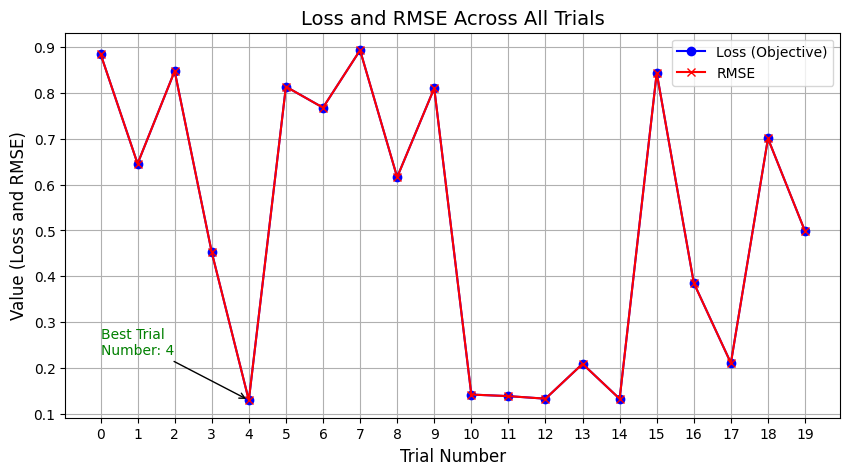


Best Trial Details:
Trial Number: 4
Loss (Objective): 0.1298
Parameters: {'learning_rate': 3.908869773882852e-05, 'batch_size': 8, 'weight_decay': 0.05458254091084816, 'num_epochs': 7, 'dropout_rate': 0.18171617704115506, 'warmup_steps': 229, 'gradient_accumulation_steps': 1}


ValueError: Unknown format code 'f' for object of type 'str'

In [35]:
import matplotlib.pyplot as plt

def plot_trials_metrics_with_all_epochs(study):
    """
    Plot the loss and RMSE for all completed trials and highlight the best trial,
    with labeled axes and integer x-axis.
    
    Args:
        study: The Optuna study object containing trials information.
    """
    trial_numbers = []
    losses = []
    rmses = []

    best_trial = None
    best_value = float('inf')  # Initialize with a very high value

    for trial in study.trials:
        if trial.state == optuna.trial.TrialState.COMPLETE:
            trial_numbers.append(trial.number)
            losses.append(trial.value)  # Assuming `value` is the loss
            rmse = trial.user_attrs.get('rmse', trial.value)  # Use custom attribute if available
            rmses.append(rmse)

            # Update best trial
            if trial.value < best_value:
                best_value = trial.value
                best_trial = trial

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(trial_numbers, losses, label='Loss (Objective)', marker='o', color='blue')
    plt.plot(trial_numbers, rmses, label='RMSE', marker='x', color='red')
    plt.xlabel('Trial Number', fontsize=12)
    plt.ylabel('Value (Loss and RMSE)', fontsize=12)
    plt.title('Loss and RMSE Across All Trials', fontsize=14)
    plt.xticks(trial_numbers)  # Set x-axis ticks to integers (trial numbers)
    plt.legend()
    plt.grid()

    # Annotate best trial
    if best_trial is not None:
        plt.annotate(
            f"Best Trial\nNumber: {best_trial.number}",
            xy=(trial_numbers[losses.index(best_trial.value)], best_trial.value),
            xytext=(trial_numbers[0], best_trial.value + 0.1),
            arrowprops=dict(facecolor='black', arrowstyle="->"),
            fontsize=10,
            color='green'
        )

    plt.show()

    # Print best trial information
    if best_trial is not None:
        print("\nBest Trial Details:")
        print(f"Trial Number: {best_trial.number}")
        print(f"Loss (Objective): {best_trial.value:.4f}")
        print(f"Parameters: {best_trial.params}")
        print(f"RMSE: {best_trial.user_attrs.get('rmse', 'N/A'):.4f}")

# Call the function for all epochs
plot_trials_metrics_with_all_epochs(study)


In [ ]:
plot_trials_metrics(study)

In [19]:
from sklearn.metrics import r2_score, mean_absolute_error , mean_squared_error

def evaluate_final_model(trainer, val_dataset):
    # Get predictions and labels
    predictions = trainer.predict(val_dataset)
    preds = predictions.predictions
    labels = predictions.label_ids

    # Compute R2 score and MAE
    r2 = r2_score(labels, preds)
    mae = mean_absolute_error(labels, preds)
    mse = mean_squared_error(labels , preds)

    print(f"R2 Score: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squarred Error (MAE): {mse:.4f}")

    return r2, mae

In [26]:
  # Evaluate final model
final_metrics = final_trainer.evaluate()
print("\nFinal model evaluation metrics:")
print(final_metrics)
# Evaluate and print metrics for final model
final_r2, final_mae = evaluate_final_model(final_trainer, val_dataset)
print("final value matrics")
print(final_r2, final_mae)
    
    # Save final model
print("\nSaving final model...")
final_trainer.save_model('./final_model')
tokenizer.save_pretrained('./final_model')
    
    # Optional: Save optimization results
import json
optimization_results = {
        'best_params': best_trial.params,
        'best_value': best_trial.value,
        'final_metrics': final_metrics,
    }
    
with open('./final_model/optimization_results.json', 'w') as f:
        json.dump(optimization_results, f, indent=4)
    
print("\nTraining complete! Model and results saved in ./final_model/")

  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Final model evaluation metrics:
{'eval_loss': 0.024166081100702286, 'eval_rmse': 0.15152841806411743, 'eval_runtime': 5.0494, 'eval_samples_per_second': 1.98, 'eval_steps_per_second': 0.396, 'epoch': 7.0}


  0%|          | 0/2 [00:00<?, ?it/s]

d:\research_models\handwritten_ocr\handwritten_ocr\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R2 Score: -0.5074
Mean Absolute Error (MAE): 0.1254
Mean Squarred Error (MAE): 0.0242
final value matrics
-0.5073630809783936 0.12538618

Saving final model...

Training complete! Model and results saved in ./final_model/
